In [21]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import timeit

%matplotlib inline

import h5py
from pathlib import Path
from jobmanager import *
from stats import spin_spin_correlation
from quantum_montecarlo import quantum_cython_mcmc

## Looking at a single run
Internally 3 representations are used:

The occupation of each site of the lattice, 0 or 1:
$$ n_i^f = 0,1$$

The simple spin variables that map n = 0 to -1/2 and 1 to 1/2
$$ u\tau_i = (2n_i^ f - 1) $$

The staggered spin variables that alternately invert the above spins variables
$$ \tau_i = (-1)^i (2n_i^ f - 1) $$

In the code I call  $<\tau_i>$ the 'magnetisation'


In [2]:
%%time
##testing a single quick run
config = dict(  N_steps = 10**2,
                N_system = 64,
                mu = 0,
                beta = 10,
                V=-1,
                alpha=1.5,
                U = 0.1,
                output_state = False,
                output_correlator=True,
                output_history=False,
                quantum = True,
                job_id = 1020242,
               )

results = quantum_cython_mcmc(**config)

CPU times: user 1.89 s, sys: 8 ms, total: 1.9 s
Wall time: 1.94 s


In [33]:
%%time
config = dict(  N_steps = 10**2,
                N_system = 64,
                mu = 0,
                beta = 0.8,
                V=-1,
                alpha=1.25,
                U = 0.1,
                output_state = True,
                output_correlator=True,
                output_history=True,
                quantum = True,
                job_id = 1020242,
               )

results = quantum_cython_mcmc(**config)
print('keys in results: ', results.keys())

states = results['states']
ts = results['ts']
energies = results['classical_energies']
numbers = results['numbers']
magnetisations = results['magnetisations']
eigenvalue_hist = results['eigenvalue_hist']
correlation = spin_spin_correlation(ts)

steps = np.arange(config['N_steps'])
sites = np.arange(config['N_system'])
print(f'''
Energy: {energies.mean()}
Number of occupied sites: {numbers.mean()}
Magnetisations of staggered spin variables: {magnetisations.mean()}
state.shape: {states.shape}
''')

keys in results:  dict_keys(['classical_energies_moments', 'numbers_moments', 'magnetisations_moments', 'quantum_energies_moments', 'classical_energies_moments_err', 'numbers_moments_err', 'magnetisations_moments_err', 'quantum_energies_moments_err', 'correlator', 'q_energy_histogram', 'classical_energies', 'numbers', 'magnetisations', 'quantum_energies', 'states', 'ts', 'eigenvalue_hist', 'eigenvector_hist'])

Energy: -0.7888467583120837
Number of occupied sites: 0.49625
Magnetisations of staggered spin variables: 0.883125
state.shape: (100, 64)

CPU times: user 2 s, sys: 8 ms, total: 2.01 s
Wall time: 2 s


## Visualising a single run

In [26]:
x = np.reshape(steps[:, np.newaxis] * np.ones_like(eigenvalue_hist), [-1,])
y = np.reshape(eigenvalue_hist, [-1])
x.shape, y.shape

((6400,), (6400,))

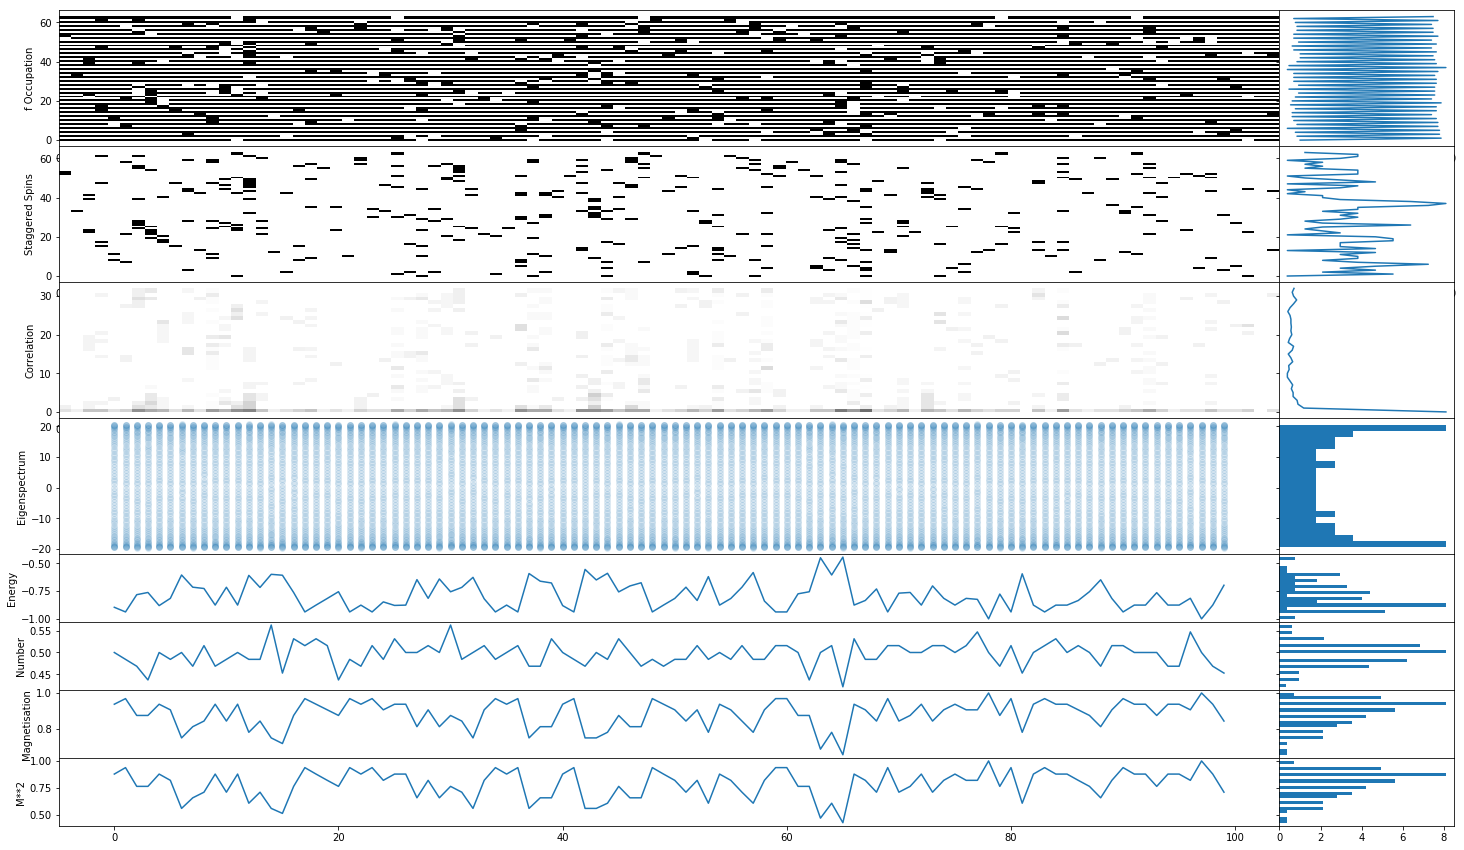

In [32]:
f, axes = plt.subplots(8,2, figsize = (25,15), sharey = 'row', gridspec_kw = dict(height_ratios=[2,2,2,2,1,1,1,1], width_ratios=[7, 1],wspace=0, hspace=0))
axs, axs1 = axes.T
observables = [_, _, _, _, energies, numbers, magnetisations, magnetisations**2]
observable_ylabels = ['f Occupation', 'Staggered Spins', 'Correlation', 'Eigenspectrum','Energy', 'Number', 'Magnetisation', 'M**2']

axs[0].pcolor(steps, sites, states.T, cmap = 'gray', vmin = 0, vmax = 1)
axs[1].pcolor(steps, sites, ts.T, cmap = 'gray', vmin = -1, vmax = 1)
axs[2].pcolor(steps, sites[:correlation.shape[-1]], 1-correlation.T, cmap = 'gray', vmin = 0, vmax = 1)

x = np.reshape(steps[:, np.newaxis] * np.ones_like(eigenvalue_hist), [-1,])
y = np.reshape(eigenvalue_hist, [-1])
axs[3].scatter(x, y, alpha = 0.1,)

#count the number of eigenvals in each square in each energy bin
indx = np.digitize(pert_vals, bins)
bin_averages= np.array([IPRs[indx == i].mean() for i in np.arange(len(bins))])

for ax,observable in list(zip(axs,observables))[4:8]: ax.plot(steps, observable)

axs1[0].plot(states.mean(axis=0), sites)
axs1[1].plot(ts.mean(axis=0), sites)
axs1[2].plot(correlation.mean(axis=0), sites[:correlation.shape[-1]])


hist_kwargs = dict(orientation='horizontal', bins = 20, density = True)
axs1[3].hist(results['eigenvalue_hist'].mean(axis=0), **hist_kwargs) 
for ax,observable in list(zip(axs1,observables))[4:8]: ax.hist(observable, **hist_kwargs)

for ylabel, ax in zip(observable_ylabels, axs): ax.set(ylabel=ylabel)
axs[5].set(xlabel = 'MC Step (One trial per site per step)');

## Histograms of observables

CPU times: user 5.17 s, sys: 81.3 ms, total: 5.26 s
Wall time: 5.26 s
keys in results:  dict_keys(['classical_energies_moments', 'numbers_moments', 'magnetisations_moments', 'quantum_energies_moments', 'classical_energies_moments_err', 'numbers_moments_err', 'magnetisations_moments_err', 'quantum_energies_moments_err', 'correlator', 'q_energy_histogram', 'classical_energies', 'numbers', 'magnetisations', 'quantum_energies', 'states', 'ts', 'eigenvalue_hist', 'eigenvector_hist'])


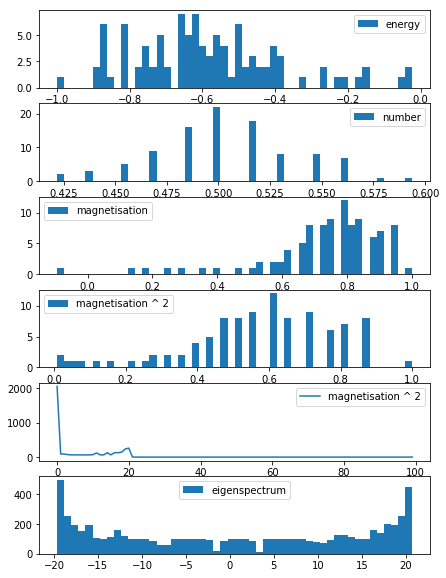

In [12]:
config = dict(  N_steps = 10**2,
                N_system = 64,
                mu = 0,
                beta = 0.68,
                V=-1,
                alpha=1.25,
                U = 0.1,
                output_state = True,
                output_correlator=True,
                output_history=True,
                quantum = True,
                job_id = 1020242,
               )

%time results = quantum_cython_mcmc(**config)
print('keys in results: ', results.keys())

states = results['states']
ts = results['ts']
energies = results['classical_energies']
numbers = results['numbers']
magnetisations = results['magnetisations']
eigenvalue_histogram = results['q_energy_histogram']
eigenvalue_hist = results['eigenvalue_hist']

steps = np.arange(config['N_steps'])
sites = np.arange(config['N_system'])

kwargs = dict(bins=50)
f, axs = plt.subplots(6, figsize = (7,10))
axs[0].hist(energies, label = 'energy', **kwargs)
axs[1].hist(numbers, label = 'number', **kwargs)
axs[2].hist(magnetisations, label = 'magnetisation', **kwargs)
axs[3].hist(magnetisations**2, label = 'magnetisation ^ 2', **kwargs)


axs[4].plot(eigenvalue_histogram, label = 'magnetisation ^ 2')
axs[5].hist(np.concatenate(eigenvalue_hist), label = 'eigenspectrum', **kwargs)


for a in axs: a.legend()

Looking at the autocorrelations defined on some set of observations $O_i$ with variance $\sigma$ and mean $\mu$ by:
$$\mu = <O>$$

$$\sigma^2 = <O^2> - <O>^2$$

$$A_{O}(t) = \frac{<(O_i - \mu)(O_{i+t}-\mu)>}{\sigma^2}$$

where the last expectation implies an average over i

## Autocorrelation of observables between MC samples

[Text(0,0.5,'Autocorrelation'), (-20, 20), Text(0.5,0,'lag time (MC samples)')]

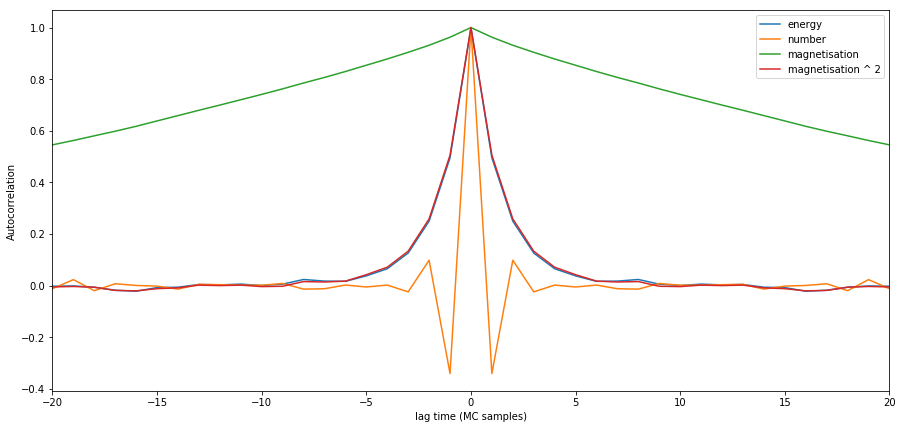

In [6]:
from stats import binned_error_estimate, autocorrelation

N = len(energies)
lags = np.arange(-N+1, N)

f, axs = plt.subplots(1, figsize = (15,7), sharex = 'col')
axs.plot(lags, autocorrelation(energies), label = 'energy')
axs.plot(lags, autocorrelation(numbers), label = 'number')
axs.plot(lags, autocorrelation(magnetisations), label = 'magnetisation')
axs.plot(lags, autocorrelation(magnetisations**2), label = 'magnetisation ^ 2')

axs.legend()

axs.set(
    xlim = (-20, +20),
    xlabel = 'lag time (MC samples)',
    ylabel = 'Autocorrelation',
          )

The autocorrelations times are quite short here so 

In [7]:
%load_ext Cython

In [8]:
%%cython --annotate
#cython: boundscheck=False, wraparound=False, infer_types=True, initializedcheck=False, cdivision=True
## test cython functions here

In [17]:
corr_graph_labels = dict(xlabel = 'Site separation (k)',
                         ylabel = 'Spin-Spin Correlation $C(k) = <s_i\;s_{i+k}> - <s>^2$',)

In [19]:
'''
%%time
import math
config = dict(  
                N_steps = 10**2,
                N_system = 64,
                mu = 0,
                V=-1,
                alpha=1.5,
                output_state = False,
                output_correlator=True,
                output_history=False,
                quantum = True,
                job_id = 1020242,
               )

sites = np.arange(config['N_system'])

N_betas = 10
betas = np.linspace(0.5,1.2,N_betas)
N_correlates = math.ceil(config['N_system']/2) + 1
corelators = np.zeros(shape = (N_betas, N_correlates))
sites = np.arange(config['N_system'])

for i,beta in enumerate(betas):
    config['beta'] = beta
    results = quantum_cython_mcmc(**config)
    corelators[i, :] = results['correlator']
''';

/home/tch14/anaconda3/envs/idp/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


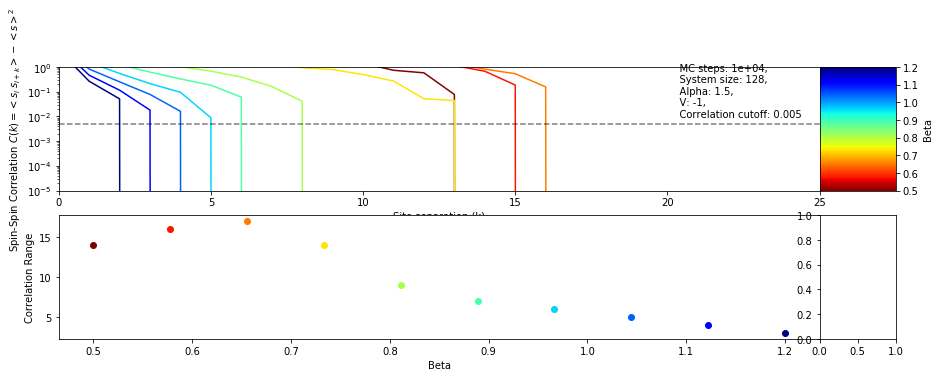

In [15]:
plot_corr(betas, corelators, sites, config, xlim = (0,25))

{'mcmc_routine': 'cython_mcmc', 'N_steps': 100000, 'N_system': 1024, 'mu': 0, 'V': -1, 'alpha': 1.5, 'loop_over': array(['beta'], dtype=object), 'output_history': False, 'output_correlator': True, 'output_state': False, 'beta': array([0.1       , 0.10954774, 0.11909548, 0.12864322, 0.13819095,
       0.14773869, 0.15728643, 0.16683417, 0.17638191, 0.18592965,
       0.19547739, 0.20502513, 0.21457286, 0.2241206 , 0.23366834,
       0.24321608, 0.25276382, 0.26231156, 0.2718593 , 0.28140704,
       0.29095477, 0.30050251, 0.31005025, 0.31959799, 0.32914573,
       0.33869347, 0.34824121, 0.35778894, 0.36733668, 0.37688442,
       0.38643216, 0.3959799 , 0.40552764, 0.41507538, 0.42462312,
       0.43417085, 0.44371859, 0.45326633, 0.46281407, 0.47236181,
       0.48190955, 0.49145729, 0.50100503, 0.51055276, 0.5201005 ,
       0.52964824, 0.53919598, 0.54874372, 0.55829146, 0.5678392 ,
       0.57738693, 0.58693467, 0.59648241, 0.60603015, 0.61557789,
       0.62512563, 0.63467337, 0.64

/home/tch14/anaconda3/envs/idp/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log
/home/tch14/anaconda3/envs/idp/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


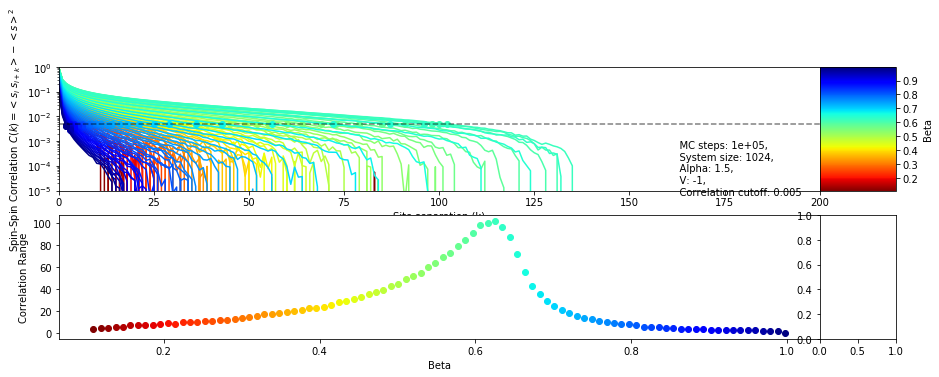

In [20]:
working_dir = Path('./data/spin_spin_correlation_functions')
result_filename = working_dir / 'results.hdf5'


def plot_corr(betas, corelators, sites, config, cutoff = 5e-3, xlim = (0,200)):
    cmap = mpl.cm.jet_r
    norm = mpl.colors.Normalize(vmin=min(betas), vmax=max(betas))
    f, ((ax, cax), (ax2, cax2)) = plt.subplots(2,2, figsize = (15,5), gridspec_kw = dict(width_ratios=[10, 1], wspace = 0))
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
    cbar.set_label('Beta')
    
    for i,beta in enumerate(betas):
        corr = corelators[i]
        color = cmap(norm(beta))
        ax.semilogy(sites[:corr.shape[-1]], corr, color=color, label = f'beta = {beta}')
        
        #find where the correlation function dips below the cutoff
        indx = np.searchsorted(-np.log(corr), -np.log(cutoff))
        cutoffs[i] = sites[indx]
        ax.plot(sites[indx], corr[indx], 'o', color=color)
        ax2.plot(beta, sites[indx], 'o', color=color)
        
    ax.plot([0,corr.shape[-1]], (cutoff,cutoff), 'k--', alpha=0.5)
    #ax2.plot(beta_range, cutoffs, 'k--', alpha = 0.5)
        
    #ax.legend()
    ax.set(
        xlim = xlim,
        ylim =  [1e-5, 1],
        **corr_graph_labels,
    );
    ax2.set(
        ylabel = 'Correlation Range',
        xlabel = 'Beta',
    );
    
    ax.text(0.8,0.5, '''
    MC steps: {N_steps:.0e},
    System size: {N_system},
    Alpha: {alpha},
    V: {V},
    Correlation cutoff: {0}
    '''.format(cutoff,**config),
        transform=ax.transAxes,
        verticalalignment = 'top',
    )
    
beta_min = 0.1
beta_max = 1.0
with h5py.File(result_filename, 'r') as data:
    print(dict(data.attrs))
    betas = data.attrs['beta']
    beta_range = betas[(betas > beta_min) & (betas < beta_max)]
    cutoffs = np.zeros_like(beta_range)
    sites = np.arange(data.attrs['N_system'])
    
    plot_corr(beta_range, data['correlator'], sites, data.attrs)
    
    
    


In [21]:
working_dir = Path('./data/spin_spin_correlation_functions_using_quantum_simulator')
result_filename = working_dir / 'results.hdf5'

with h5py.File(result_filename, 'r') as data:
    betas = data.attrs['beta']
    beta_range = betas[(betas > beta_min) & (betas < beta_max)]
    cutoffs = np.zeros_like(beta_range)
    sites = np.arange(data.attrs['N_system'])
    print(dict(data))
    
    plot_corr(beta_range, data['correlator'], sites, data.attrs)

{'classical_energies': <HDF5 dataset "classical_energies": shape (200, 100000), type "<f8">, 'energies': <HDF5 dataset "energies": shape (200, 100000), type "<f8">, 'magnetisations': <HDF5 dataset "magnetisations": shape (200, 100000), type "<f8">, 'numbers': <HDF5 dataset "numbers": shape (200, 100000), type "<f8">, 'quantum_energies': <HDF5 dataset "quantum_energies": shape (200, 100000), type "<f8">, 'runtime': <HDF5 dataset "runtime": shape (200, 1), type "<i8">}


KeyError: "Unable to open object (object 'correlator' doesn't exist)"

Each line shows the correlation function for a particular value of beta. 

['correlator', 'energies', 'energy_moments', 'energy_moments_err', 'magnetisation_moments', 'magnetisation_moments_err', 'magnetisations', 'number_moments', 'number_moments_err', 'numbers', 'states', 'ts']
['alpha' 'beta']


/home/tch14/anaconda3/envs/idp/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt



        MC steps: 1e+04,
        System size: 1024,
        Alpha: 1.5,
        V: -1,
        


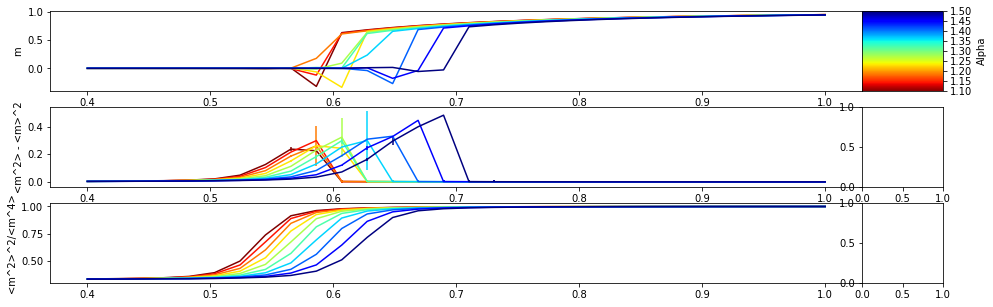

In [41]:
def plot_alpha_study(wdir):
    result_filename = wdir / 'results.hdf5'
    with h5py.File(result_filename, 'r') as data:
        print(list(data.keys()))
        print(data.attrs['loop_over'])

        betas = data.attrs['beta']
        alphas = data.attrs['alpha']

        cmap = mpl.cm.jet_r
        norm = mpl.colors.Normalize(vmin=min(alphas), vmax=max(alphas))
        f, axes = plt.subplots(3,2, figsize = (16,5), gridspec_kw = dict(width_ratios=[10, 1], wspace = 0))
        axs = axes[:, 0]
        cbar = mpl.colorbar.ColorbarBase(axes[0,1], cmap=cmap, norm=norm, orientation='vertical')
        cbar.set_label('Alpha')

        for i,alpha in enumerate(alphas):
            color = cmap(norm(alpha))
            plt_kwargs = dict(color = color)
            #axes: N_system, beta, alpha, mcmc_step
            mags = data['magnetisation_moments']
            dm = data['magnetisation_moments_err'][i]

            m = mags[i, :, 0]
            m2 = mags[i, :, 1]
            m4 = mags[i, :, 3]

            axs[0].plot(betas, m, label = f'alpha={alpha:.2f}', **plt_kwargs)
            axs[1].errorbar(betas, m2 - m**2, yerr = np.sqrt(dm[:,1]**2 + 2*m*dm[:,0]), **plt_kwargs)
            axs[2].errorbar(betas, m2**2/m4, **plt_kwargs)

        print('''
        MC steps: {N_steps:.0e},
        System size: {N_system},
        Alpha: {alpha},
        V: {V},
        '''.format(cutoff,**config).format(**data.attrs))
        
        for ax, label in zip(axs, ['m', '<m^2> - <m>^2', '<m^2>^2/<m^4>']):
            ax.set(ylabel = label)
 
working_dir = Path('./data/luijten_paper_Q')
plot_alpha_study(working_dir)

['energy_moments', 'energy_moments_err', 'magnetisation_moments', 'magnetisation_moments_err', 'number_moments', 'number_moments_err', 'runtime', 'time']
['alpha' 'beta']


/home/tch14/anaconda3/envs/idp/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide



        MC steps: 1e+04,
        System size: 1024,
        Alpha: 1.5,
        V: -1,
        


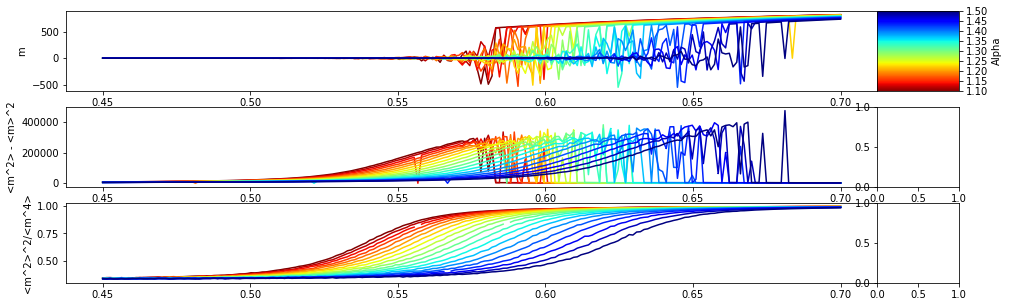

In [42]:
working_dir = Path('./data/luijten_paper_Q_finer')
plot_alpha_study(working_dir)

In [3]:
%%time
import math
config = dict(  
                beta = 0.6,
                N_steps = 10**2,
                N_system = 64,
                mu = 0,
                V=-100,
                alpha=1.5,
                output_state = True,
                output_correlator=False,
                output_history=False,
                quantum = True,
                job_id = 1020242,
               )


results = quantum_cython_mcmc(**config)
dict(results)

CPU times: user 4.67 s, sys: 21.2 ms, total: 4.7 s
Wall time: 5.75 s


In [18]:
results

{'classical_energies_moments': array([-9.67342253e-01,  4.10944422e+01, -2.62150425e+03,  1.67772195e+05,
        -1.07374183e+07,  6.87194767e+08, -4.39804651e+10,  2.81474977e+12,
        -1.80143985e+14]),
 'quantum_energies_moments': array([1.74369190e+00, 4.89001261e+01, 3.30397648e+03, 2.28301931e+05,
        1.57809813e+07, 1.09083927e+09, 7.54028143e+10, 5.21211931e+12,
        3.60280820e+14]),
 'numbers_moments': array([8.52343750e-01, 1.05286401e+01, 3.27837793e+02, 1.04858470e+04,
        3.35544368e+05, 1.07374183e+07, 3.43597384e+08, 1.09951163e+10,
        3.51843721e+11]),
 'magnetisations_moments': array([8.10937500e-01, 4.11766699e+01, 2.62151485e+03, 1.67772247e+05,
        1.07374183e+07, 6.87194767e+08, 4.39804651e+10, 2.81474977e+12,
        1.80143985e+14]),
 'q_energy_histogram_moments': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'classical_energies_moments_err': array([6.41102293e-01, 4.09626585e+01, 2.62144264e+03, 1.67772162e+05,
        1.07374182e+07, 6.

(array([   0.,    0.,    0.,    0.,    0., 6400.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

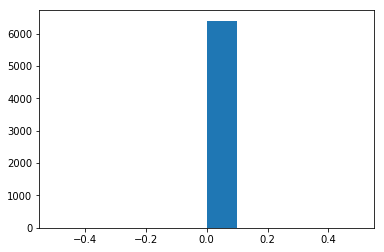

In [20]:
f, ax = plt.subplots(1)
eig_vals = np.concatenate(results['eigenvalue_hist'])
ax.hist(eig_vals)